In [8]:
import re
import qiskit

In [65]:
def QASMDict(gates):
#     print(gates)
    qasmDict = {} #  {'qbit number' : []}
#     print(gates)
    count = []
    for x in range(len(gates)):
        if x == 1 or x == 0:
            continue
        if gates[x][0] == 'qreg':
            for y in range(int(gates[x][1][2])):
                qasmDict[str(y)] = []
#         print(list(qasmDict.keys()))
        if len(count) == 0:
            for b in list(qasmDict.keys()):
                count.append(0)
#         print(count)
        if gates[x][0] != 'OPENQASM' and gates[x][0] != 'include' and gates[x][0] != 'qreg' and gates[x][0] != 'creg' and gates[x][0] != 'measure':
            if len(gates[x])-1 > 1:
                if count[int(gates[x][1][2])] > count[int(gates[x][2][2])]:
                    qasmDict[str(gates[x][2][2])].append([])
                    count[int(gates[x][2][2])] += 1
                elif count[int(gates[x][1][2])] < count[int(gates[x][2][2])]:
                    qasmDict[str(gates[x][1][2])].append([])
                    count[int(gates[x][1][2])] += 1
                qasmDict[str(gates[x][2][2])].append(gates[x])
                qasmDict[str(gates[x][1][2])].append(gates[x])
            else:
                qasmDict[str(gates[x][1][2])].append(gates[x])
                count[int(gates[x][1][2])] += 1
#             for z in range(len(gates[x])-1):
#                 qasmDict[str(gates[x][z+1][2])].append(gates[x])
#                 count[int(gates[x][z+1][2])] += 1
#         print(count.index(min(count)))
#         print(count.index(max(count)))
        uneven = True
        while uneven:
            uneven = False
            minInd = count.index(min(count))
            maxInd = count.index(max(count))
            if count[maxInd] > count[minInd] + 1:
                qasmDict[str(minInd)].append([])
                count[minInd] += 1
                uneven = True
#         for a in count:
            
    return qasmDict

def openQASM(qasm_loc):
    qasm_f = open(qasm_loc, "r")
    gates = []
    for line in qasm_f:
        gates.append( list(filter(None, re.split(" |,", line.strip()[:-1]))) )
#     print(gates)
    qasmDict = QASMDict(gates)
    qasm_f.close()
    return qasmDict


In [130]:
#MAIN SWAPS
def HHtoNone(qubit, depth, circuitDict):
    index2 = depth + 1
    if circuitDict[str(qubit)][depth + 1] == []:
        for x in range(depth+1,len(circuitDict[str(qubit)])):
            if circuitDict[str(qubit)][x] != []:
                index2 = x
                break
    circuitDict[str(qubit)][index2] = []
    circuitDict[str(qubit)][depth] = []
    return circuitDict


def NonetoHH(qubit, depth, circuitDict):
    qString = 'q[' + str(qubit) + ']'
    circuitDict[str(qubit)].insert(depth, ['h', qString])
    circuitDict[str(qubit)].insert(depth, ['h', qString])
    return circuitDict


# Depth is cz depth
def HZHtoCX(qubit, depth, circuitDict):
    qString = 'q[' + str(qubit) + ']'
    circuitDict[circuitDict[str(qubit)][depth][1][2]][depth][0] = 'cx'
    circuitDict[str(qubit)][depth-1] = []
    circuitDict[str(qubit)][depth][0] = 'cx'
    circuitDict[str(qubit)][depth+1] = []
#     print(circuitDict[circuitDict[str(qubit)][depth][1][2]][depth])
    return circuitDict

# Depth is cx depth
def CXtoHZH(qubit, depth, circuitDict):
    qString = 'q[' + str(qubit) + ']'
    circuitDict[str(qubit)][depth][0] = 'cz'
    circuitDict[circuitDict[str(qubit)][depth][1][2]][depth][0] = 'cz'
    circuitDict[str(qubit)].insert(depth+1, ['h', qString])
    circuitDict[str(qubit)].insert(depth, ['h', qString])
    print(circuitDict)
    
    

In [131]:
def dictToQasm(circuitDict):
    outText = "OPENQASM 2.0;\ninclude \"qelib1.inc\";"
#     print(len(circuitDict.keys()))
    outText += '\nqreg q[' + str(len(circuitDict.keys())) + '];\ncreg c[' + str(len(circuitDict.keys())) + '];\n'
    
    maxind = 0
    for x in range(len(circuitDict.keys())):
#         print(x)
        if len(circuitDict[str(x)]) > len(circuitDict[str(maxind)]):
            maxind = x
    ind = 0
    while len(circuitDict[str(maxind)]) > ind:
        for y in range(len(circuitDict.keys())):
            if len(circuitDict[str(y)]) > ind:
                if circuitDict[str(y)][ind] == []:
                    continue
                elif len(circuitDict[str(y)][ind]) == 2:
                    outText += circuitDict[str(y)][ind][0] + ' ' + circuitDict[str(y)][ind][1] + ';\n'
                elif len(circuitDict[str(y)][ind]) == 3:
                    if circuitDict[str(y)][ind][2][2] == str(y):
                        outText += circuitDict[str(y)][ind][0] + ' ' + circuitDict[str(y)][ind][1] + ',' + circuitDict[str(y)][ind][2] + ';\n'
        ind += 1
    for z in range(len(circuitDict.keys())):
        outText += 'measure q[' + str(z) + '] -> c[' + str(z) + '];\n'
            
    return outText

In [132]:
circuit = openQASM('circuit.qasm')
print(circuit)
dictToQasm(circuit)
print(HZHtoCX(0,1,circuit))
dictToQasm(circuit)
CXtoHZH(0, 1, circuit)
# print(circuit)

{'0': [['h', 'q[0]'], ['cz', 'q[1]', 'q[0]'], ['h', 'q[0]']], '1': [[], ['cz', 'q[1]', 'q[0]']]}
{'0': [[], ['cx', 'q[1]', 'q[0]'], []], '1': [[], ['cx', 'q[1]', 'q[0]']]}
{'0': [[], ['h', 'q[0]'], ['cz', 'q[1]', 'q[0]'], ['h', 'q[0]'], []], '1': [[], ['cz', 'q[1]', 'q[0]']]}


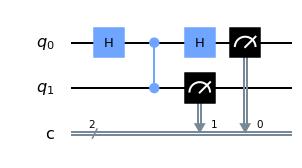

In [133]:
circ = qiskit.QuantumCircuit.from_qasm_file('circuit.qasm')
circ.draw(output='mpl')

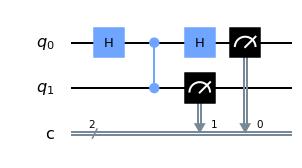

In [134]:
circ_out = qiskit.QuantumCircuit.from_qasm_str(dictToQasm(circuit))
circ_out.draw(output='mpl')